# Decision Tree

### 1. Set up spark context and SparkSession

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark Decision Tree classification") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### 2. Load dataset

In [2]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true').load("../data/WineData2.csv",header=True);

In [3]:
df.show(5,True)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8|      5|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8|      6|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows



In [4]:
df.printSchema()

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free: double (nullable = true)
 |-- total: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [5]:
# Convert to float format
def float_to_string(x):
    return string(x)

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
float_to_string_udf = udf(float_to_string, StringType())

In [6]:
df.printSchema()

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free: double (nullable = true)
 |-- total: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



### 3. Convert the data to dense vector

In [7]:
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [8]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

### 4. Transform the dataset to DataFrame

In [9]:
transformed = transData(df)

In [10]:
transformed.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[7.4,0.7,0.0,1.9,...|    5|
|[7.8,0.88,0.0,2.6...|    5|
|[7.8,0.76,0.04,2....|    5|
+--------------------+-----+
only showing top 3 rows



In [11]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)

In [12]:
labelIndexer.transform(transformed).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|[7.4,0.7,0.0,1.9,...|    5|         0.0|
|[7.8,0.88,0.0,2.6...|    5|         0.0|
|[7.8,0.76,0.04,2....|    5|         0.0|
|[11.2,0.28,0.56,1...|    6|         1.0|
|[7.4,0.7,0.0,1.9,...|    5|         0.0|
+--------------------+-----+------------+
only showing top 5 rows



In [13]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed) 

In [14]:
featureIndexer.transform(transformed).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[7.4,0.7,0.0,1.9,...|    5|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|    5|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|    5|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|    6|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|    5|[7.4,0.7,0.0,1.9,...|
+--------------------+-----+--------------------+
only showing top 5 rows



### 5. Split the data to training and test data sets

In [15]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

### 6. Fit Decision Tree Classification Model

In [16]:
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [17]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [18]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

In [19]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [20]:
from pyspark.ml.linalg import SparseVector, DenseVector
model.stages[-2].featureImportances

SparseVector(11, {0: 0.0412, 1: 0.1002, 2: 0.0339, 3: 0.047, 5: 0.05, 6: 0.1716, 7: 0.0321, 8: 0.0109, 9: 0.1245, 10: 0.3886})

### 7. Make predictions

In [21]:
# Make predictions.
predictions = model.transform(testData)

In [22]:
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[4.6,0.52,0.15,2....|    4|             7|
|[4.9,0.42,0.0,2.1...|    7|             7|
|[5.0,1.02,0.04,1....|    4|             5|
|[5.1,0.47,0.02,1....|    6|             7|
|[5.1,0.51,0.18,2....|    7|             7|
+--------------------+-----+--------------+
only showing top 5 rows



In [23]:
predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- indexedLabel: double (nullable = true)
 |-- indexedFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)
 |-- predictedLabel: string (nullable = true)



### 8. Evaluation

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.423477
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4c1cbfaf577b21de49eb) of depth 5 with 59 nodes


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("indexedLabel")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[186,  97,  13,   0,   0,   0],
       [ 55, 166,  43,   0,   0,   0],
       [  6,  35,  36,   0,   0,   0],
       [  9,  13,   1,   0,   0,   0],
       [  2,   3,   5,   0,   0,   0],
       [  2,   1,   0,   0,   0,   0]])

In [27]:
# # Plot non-normalized confusion matrix
class_temp = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # # print(class_name)
class_names

['5', '6', '7', '4', '8', '3']

In [28]:
#class_names = [ '5','6','7','4','8','3']

Confusion matrix, without normalization
[[186  97  13   0   0   0]
 [ 55 166  43   0   0   0]
 [  6  35  36   0   0   0]
 [  9  13   1   0   0   0]
 [  2   3   5   0   0   0]
 [  2   1   0   0   0   0]]


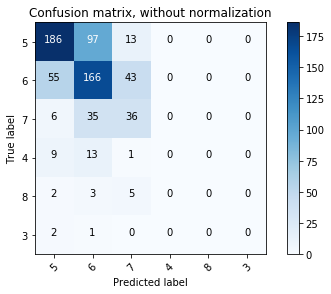

In [29]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Confusion matrix, without normalization
[[186  97  13   0   0   0]
 [ 55 166  43   0   0   0]
 [  6  35  36   0   0   0]
 [  9  13   1   0   0   0]
 [  2   3   5   0   0   0]
 [  2   1   0   0   0   0]]


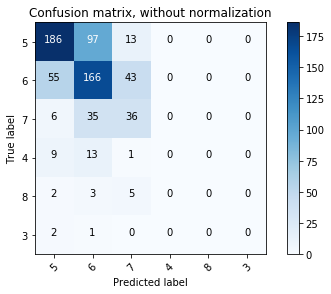

In [30]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [31]:
predictions.select("label").filter(predictions.label==6).count()

264

### 9. Cross-Validation

In [32]:
# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

In [33]:
# Set F-1 score as evaluation metric for best model selection
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction', metricName='f1')    

In [34]:
# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [35]:
# Train model.  This also runs the indexers.
dTree_model = crossval.fit(transformed)

#### Fetch best model

In [36]:
# Fetch best model
tree_model = dTree_model.bestModel
tree_model

PipelineModel_4d4a9e3b043f05afab34

In [37]:
# Make predictions.
predictions = tree_model.transform(transformed)
predictions_test = tree_model.transform(testData)

In [38]:
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[7.4,0.7,0.0,1.9,...|    5|             5|
|[7.8,0.88,0.0,2.6...|    5|             5|
|[7.8,0.76,0.04,2....|    5|             5|
|[11.2,0.28,0.56,1...|    6|             6|
|[7.4,0.7,0.0,1.9,...|    5|             5|
+--------------------+-----+--------------+
only showing top 5 rows



In [39]:
evaluator.evaluate(predictions)

0.7549574920851149

In [40]:
evaluator.evaluate(predictions_test)

0.76671783127146